In [219]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics
from celldreamer.eval.evaluate import compute_prdc
import scipy.sparse as sparse
import scipy as sp

from torch import nn
import scanpy as sc    

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
import random
from celldreamer.models.base.encoder_model import EncoderModel
from celldreamer.models.base.utils import unsqueeze_right

from celldreamer.paths import DATA_DIR

device  = "cuda" if torch.cuda.is_available() else "cpu"

**Util function**

In [194]:
def init_feature_embeddings(dataset, dataset_config, device):
    feature_embeddings = {}  
    num_classes = {}
            
    for cov, cov_names in dataset.id2cov.items():
        feature_embeddings[cov] = CategoricalFeaturizer(len(cov_names), 
                                                                  dataset_config["one_hot_encode_features"], 
                                                                  device, 
                                                                  embedding_dimensions=dataset_config["cov_embedding_dimensions"])
        if dataset_config["one_hot_encode_features"]:
            num_classes[cov] = len(cov_names)
        else:
            num_classes[cov] = dataset_config["cov_embedding_dimensions"]
    return feature_embeddings

## Step 1: Initialize data

In [195]:
dataset_config = {'dataset_path': DATA_DIR / 'processed' / 'classifier_experiment' / 'pbmc_covid_train.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['cell_type'],
                    'conditioning_covariate': 'cell_type',
                    'subsample_frac': 1,
                    'encoder_type': 'learnt_autoencoder',
                    'target_max': 1,
                    'target_min': -1,
                    'one_hot_encode_features': False,
                    'split_rates': [0.90, 0.05, 0.05],
                    'cov_embedding_dimensions': 256}

data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                                layer_key=dataset_config["layer_key"],
                                covariate_keys=dataset_config["covariate_keys"],
                                subsample_frac=dataset_config["subsample_frac"], 
                                encoder_type=dataset_config["encoder_type"],
                                target_max=dataset_config["target_max"], 
                                target_min=dataset_config["target_min"])

dataloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=256,
                                            shuffle=True,
                                            num_workers=4, 
                                            drop_last=True)

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}
scaler = dataset.get_scaler()
n_cat = len(dataset.id2cov["cell_type"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


## Step 2: Initialize encoder

In [196]:
encoder_config = {
    "encoder_kwargs": {
        "dims": [512, 256, 50],
        "batch_norm": True,
        "dropout": False,
        "dropout_p": 0.0
    },
    "learning_rate": 0.001,
    "weight_decay": 0.00001,
    "covariate_specific_theta": False
}

state_dict_path = "/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/train_autoencoder_pbmc_covid/21d30ca0-932d-4891-9796-938e9033b267/checkpoints/last.ckpt"

In [197]:
encoder_model = EncoderModel(in_dim=in_dim,
                              scaler=scaler, 
                              n_cat=n_cat,
                              conditioning_covariate=dataset_config["conditioning_covariate"], 
                              encoder_type=dataset_config["encoder_type"],
                              **encoder_config)

encoder_model.load_state_dict(torch.load(state_dict_path)["state_dict"])

encoder_model.eval()

EncoderModel(
  (x0_from_x): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=2000, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (1): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (2): Linear(in_features=256, out_features=50, bias=True)
    )
  )
  (x_from_x0): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=50, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running

## Initialize FM model

In [198]:
generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'sigma': 0.0001
                        }

In [199]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/fm_resnet_autoencoder_pbmc_covid_whole_genome/a075cbb3-f9d8-4c34-bc3d-139ba928ba56/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model.multimodal = False

In [200]:
denoising_model.embed_size_factor = True

In [201]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["cell_type"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[-2.6352, -0.3629, -0.4067,  ...,  0.2508, -0.0170, -0.7093],
        [ 2.3055, -0.2089,  0.3508,  ...,  0.0629,  1.0793,  1.6488],
        [ 1.5015,  1.1049, -0.8106,  ...,  0.3859, -0.1244,  1.3552],
        ...,
        [ 1.3194,  1.0029, -3.6609,  ...,  0.3767, -0.1811,  1.9171],
        [ 0.7573,  1.5707,  0.3263,  ...,  1.5110,  0.9219, -2.6991],
        [-0.5664,  0.6156, -0.3074,  ...,  1.2680,  0.8071,  1.5441]],
       device='cuda:0', requires_grad=True)


Initializations

In [202]:
generative_model = FM(
            encoder_model=encoder_model,
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=512,
            size_factor_statistics=size_factor_statistics,
            scaler=scaler,
            encoder_type=dataset_config["encoder_type"],
            conditioning_covariate=dataset_config["conditioning_covariate"],
            model_type=denoising_model.model_type, 
            **generative_model_config  # model_kwargs should contain the rest of the arguments
            )

generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (encoder_model): EncoderModel(
    (x0_from_x): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=2000, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=512, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (2): Linear(in_features=256, out_features=50, bias=True)
      )
    )
    (x_from_x0): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=50, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          

**Check the data**

In [203]:
adata_original = sc.read_h5ad(data_path)
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)
X = torch.tensor(adata_original.layers["X_counts"].todense())

In [204]:
adata_original

AnnData object with n_obs × n_vars = 344820 × 2000
    obs: 'Ethnicity', 'BMI', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'Age_group', 'COVID_severity', 'COVID_status', 'Group', 'Smoker', 'sample_id', 'sequencing_library', 'Protein_modality_weight', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'size_factor'
    var: 'name', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'antibody_X', 'antibody_features', 'cell_type_colors',

In [205]:
unique_classes = np.unique(adata_original.obs.cell_type, return_counts=True)
class_freq_dict = dict(zip(unique_classes[0], unique_classes[1]))
norm_const = np.sum(1/unique_classes[1])
class_prop_dict = dict(zip(unique_classes[0], (1/unique_classes[1])/norm_const))
class_prop = (1/unique_classes[1])/norm_const
class_idx = dict(zip(range(len(unique_classes[0])), unique_classes[0]))

In [224]:
class_freq_dict

{'B cell': 1390,
 'CD16-negative, CD56-bright natural killer cell, human': 3832,
 'CD4-positive helper T cell': 30813,
 'CD4-positive, alpha-beta cytotoxic T cell': 4906,
 'CD8-positive, alpha-beta cytotoxic T cell': 32672,
 'central memory CD8-positive, alpha-beta T cell': 10822,
 'class switched memory B cell': 3289,
 'classical monocyte': 43154,
 'conventional dendritic cell': 1977,
 'dendritic cell': 44,
 'effector memory CD8-positive, alpha-beta T cell': 2131,
 'effector memory CD8-positive, alpha-beta T cell, terminally differentiated': 5580,
 'erythrocyte': 328,
 'gamma-delta T cell': 4269,
 'granulocyte': 24,
 'hematopoietic precursor cell': 815,
 'innate lymphoid cell': 343,
 'mature NK T cell': 616,
 'mucosal invariant T cell': 3421,
 'naive B cell': 37844,
 'naive thymus-derived CD4-positive, alpha-beta T cell': 66988,
 'naive thymus-derived CD8-positive, alpha-beta T cell': 27166,
 'natural killer cell': 43554,
 'non-classical monocyte': 7928,
 'plasma cell': 1385,
 'plasma

In [206]:
class_prop_dict

{'B cell': 0.008510976391724509,
 'CD16-negative, CD56-bright natural killer cell, human': 0.0030872278665180232,
 'CD4-positive helper T cell': 0.0003839372078180335,
 'CD4-positive, alpha-beta cytotoxic T cell': 0.0024113854839985867,
 'CD8-positive, alpha-beta cytotoxic T cell': 0.0003620916131396017,
 'central memory CD8-positive, alpha-beta T cell': 0.0010931673613469846,
 'class switched memory B cell': 0.00359691614001127,
 'classical monocyte': 0.0002741404547549953,
 'conventional dendritic cell': 0.005983943947646468,
 'dendritic cell': 0.26886948146584244,
 'effector memory CD8-positive, alpha-beta T cell': 0.005551505013841889,
 'effector memory CD8-positive, alpha-beta T cell, terminally differentiated': 0.0021201177749994742,
 'erythrocyte': 0.03606785726980813,
 'gamma-delta T cell': 0.0027712010270548293,
 'granulocyte': 0.49292738268737774,
 'hematopoietic precursor cell': 0.014515652987112966,
 'innate lymphoid cell': 0.034490545727396696,
 'mature NK T cell': 0.01920

## General conditional

In [207]:
n_to_sample = 800000 - adata_original.shape[0]

In [208]:
np.random.seed(42)
samples = np.random.choice(range(len(class_idx)), size=n_to_sample, replace=True, p=sp.special.softmax(class_prop))

In [209]:
condition_val.shape

torch.Size([450000])

In [210]:
condition_names = [class_idx[sample] for sample in samples][:450000]
condition_val = torch.tensor([dataset.id2cov["cell_type"][condition_name] for condition_name in condition_names]).long()

X_generated = generative_model.batched_sample(batch_size=450,
                                            repetitions=1000,
                                            n_sample_steps=2, 
                                            covariate="cell_type", 
                                            covariate_indices=condition_val, 
                                            log_size_factor=None)

# X_generated_list= X_generated.to("cpu")

**Create adata and check plots**

In [212]:
adata_generated = sc.AnnData(X=sparse.csr_matrix(deepcopy(X_generated).cpu().numpy()))

In [213]:
generated_classes = np.unique(condition_names, return_counts=True)
generated_classes_dict = dict(zip(generated_classes[0], generated_classes[1]))

In [223]:
generated_classes_dict

{'B cell': 15098,
 'CD16-negative, CD56-bright natural killer cell, human': 15193,
 'CD4-positive helper T cell': 15269,
 'CD4-positive, alpha-beta cytotoxic T cell': 14877,
 'CD8-positive, alpha-beta cytotoxic T cell': 15074,
 'central memory CD8-positive, alpha-beta T cell': 14952,
 'class switched memory B cell': 15315,
 'classical monocyte': 15102,
 'conventional dendritic cell': 14968,
 'dendritic cell': 19976,
 'effector memory CD8-positive, alpha-beta T cell': 15148,
 'effector memory CD8-positive, alpha-beta T cell, terminally differentiated': 14958,
 'erythrocyte': 15479,
 'gamma-delta T cell': 15298,
 'granulocyte': 24568,
 'hematopoietic precursor cell': 15325,
 'innate lymphoid cell': 15607,
 'mature NK T cell': 15516,
 'mucosal invariant T cell': 15213,
 'naive B cell': 15169,
 'naive thymus-derived CD4-positive, alpha-beta T cell': 15095,
 'naive thymus-derived CD8-positive, alpha-beta T cell': 14968,
 'natural killer cell': 15156,
 'non-classical monocyte': 15205,
 'plas

In [ ]:
sc.pp.log1p(adata_generated)
sc.tl.pca(adata_generated)
sc.pp.neighbors(adata_generated)
sc.tl.umap(adata_generated)

IOStream.flush timed out


In [ ]:
adata_generated.obs["size_factor"] = adata_generated.X.sum(1)

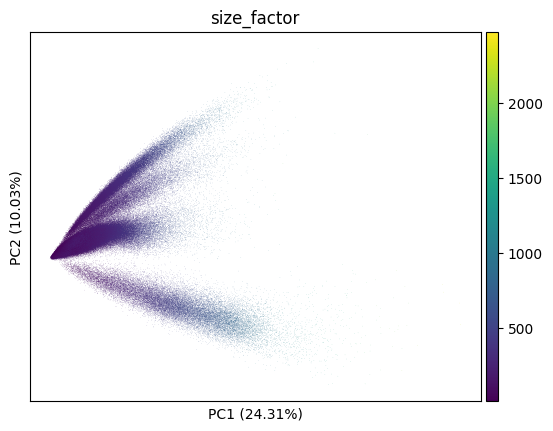

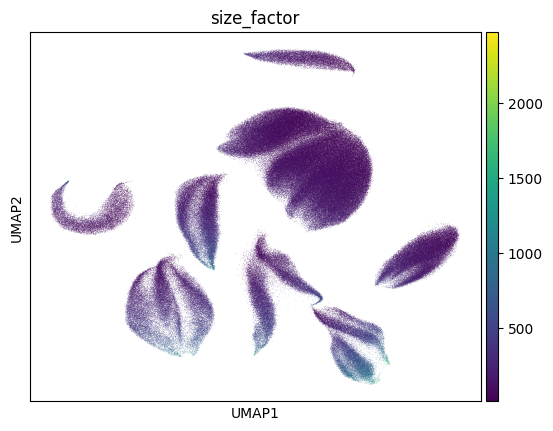

In [222]:
sc.pl.pca(adata_generated, color="size_factor", annotate_var_explained=True)
sc.pl.umap(adata_generated, color="size_factor")

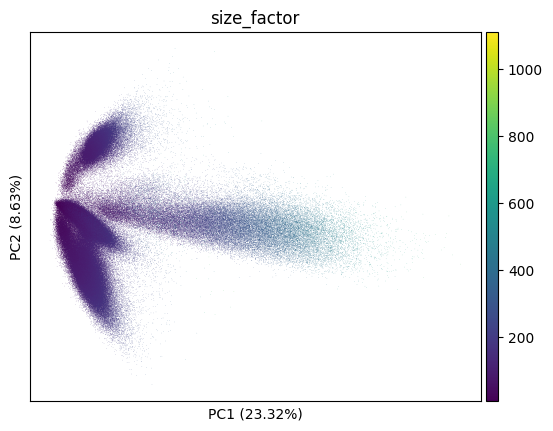

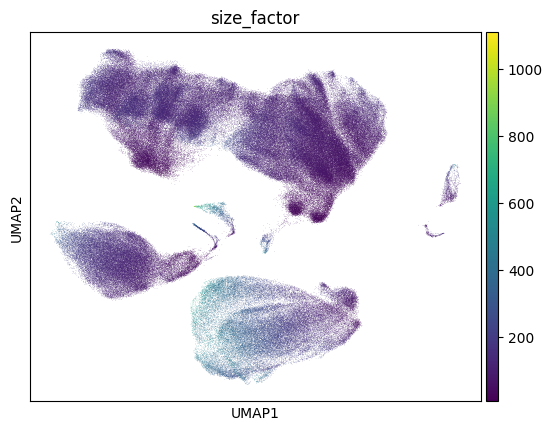

In [225]:
sc.pl.pca(adata_original, color="size_factor",  annotate_var_explained=True)
sc.pl.umap(adata_original, color="size_factor")

Merge and plot the generated and real data

In [244]:
dataset_type = ["Real" for _ in range(X.shape[0])] + ["Generated" for _ in range(X_generated.shape[0])]
dataset_type = pd.DataFrame(dataset_type)
dataset_type.columns = ["dataset_type"]
dataset_type["cell_type"] = list(adata_original.obs.cell_type)+condition_names[:450000]

In [245]:
adata_merged = sc.AnnData(X=torch.cat([X, X_generated], dim=0).numpy(), 
                             obs=dataset_type)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [247]:
sc.pp.log1p(adata_merged) 
sc.tl.pca(adata_merged)
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


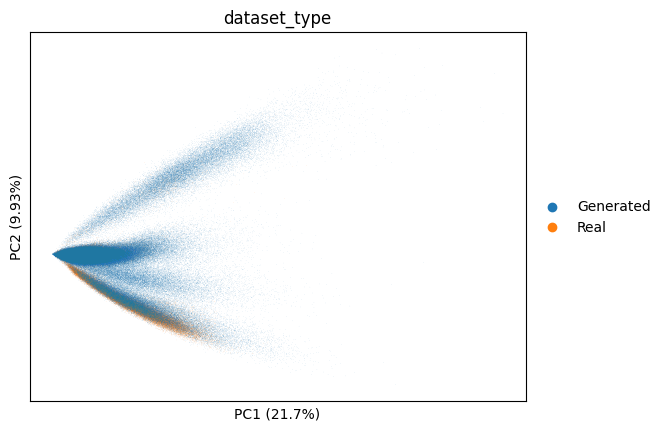

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoi

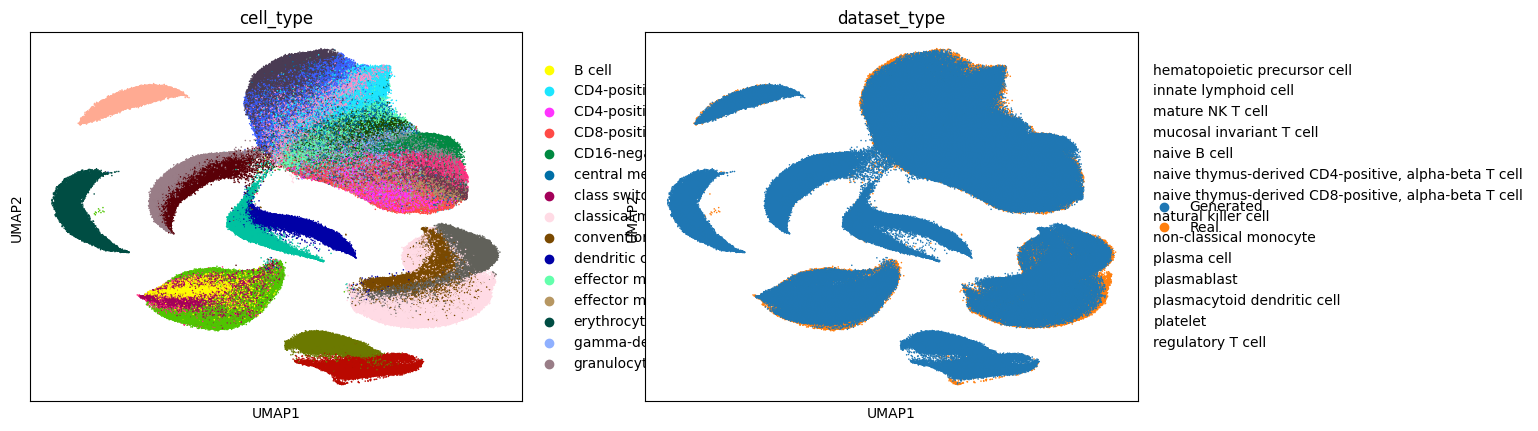

In [249]:
sc.pl.pca(adata_merged, color="dataset_type",  annotate_var_explained=True)
sc.pl.umap(adata_merged, color=["cell_type","dataset_type"], s=5)
# sc.pl.umap(adata_merged[adata_merged.obs.dataset_type=="Real"], color=["classes"])

In [258]:
unique_cell_types_augmented = np.unique(adata_merged.obs.cell_type, return_counts=True)

In [259]:
dict(zip(unique_cell_types_augmented[0], unique_cell_types_augmented[1]))

{'B cell': 16326,
 'CD16-negative, CD56-bright natural killer cell, human': 18856,
 'CD4-positive helper T cell': 45918,
 'CD4-positive, alpha-beta cytotoxic T cell': 19636,
 'CD8-positive, alpha-beta cytotoxic T cell': 47581,
 'central memory CD8-positive, alpha-beta T cell': 25617,
 'class switched memory B cell': 18412,
 'classical monocyte': 58074,
 'conventional dendritic cell': 16781,
 'dendritic cell': 19785,
 'effector memory CD8-positive, alpha-beta T cell': 17112,
 'effector memory CD8-positive, alpha-beta T cell, terminally differentiated': 20343,
 'erythrocyte': 15647,
 'gamma-delta T cell': 19380,
 'granulocyte': 24315,
 'hematopoietic precursor cell': 15960,
 'innate lymphoid cell': 15770,
 'mature NK T cell': 15944,
 'mucosal invariant T cell': 18452,
 'naive B cell': 52860,
 'naive thymus-derived CD4-positive, alpha-beta T cell': 81916,
 'naive thymus-derived CD8-positive, alpha-beta T cell': 41949,
 'natural killer cell': 58518,
 'non-classical monocyte': 22972,
 'plas

In [264]:
sc.write("/home/icb/alessandro.palma/environment/celldreamer/project_folder/datasets/processed/classifier_experiment/augmented/pbmc_covid_augmented_prop.h5ad", adata_merged)